In [1]:
# Load required libraries
install.packages("randomForest")
install.packages("keras3")
install.packages("xgboost")
install.packages("ggplot2")
install.packages("corrplot")
install.packages("e1071")  # For SVM
install.packages("rpart")  # For Decision Tree

library(keras3)
library(xgboost)
library(randomForest)
library(ggplot2)
library(corrplot)
library(e1071)
library(rpart)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


corrplot 0.95 loaded



In [2]:
# Load and summarize the dataset
dataset <- read.csv("/content/station00.csv")

In [8]:
# Display column names and the first five rows of the dataset
cat("Column names of the dataset:\n")
print(names(dataset))

cat("First five rows of the dataset:\n")
print(head(dataset, 5))

Column names of the dataset:
 [1] "date_time"         "nwp_globalirrad"   "nwp_directirrad"  
 [4] "nwp_temperature"   "nwp_humidity"      "nwp_windspeed"    
 [7] "nwp_winddirection" "nwp_pressure"      "lmd_totalirrad"   
[10] "lmd_diffuseirrad"  "lmd_temperature"   "lmd_pressure"     
[13] "lmd_winddirection" "lmd_windspeed"     "power"            
First five rows of the dataset:
            date_time nwp_globalirrad nwp_directirrad nwp_temperature
1 2018-08-15 16:00:00               0               0           22.78
2 2018-08-15 16:15:00               0               0           22.75
3 2018-08-15 16:30:00               0               0           22.71
4 2018-08-15 16:45:00               0               0           22.64
5 2018-08-15 17:00:00               0               0           22.57
  nwp_humidity nwp_windspeed nwp_winddirection nwp_pressure lmd_totalirrad
1        96.85          4.28            339.41      1007.27              0
2        96.91          4.30            337.

In [9]:
# Check for missing values
cat("Checking for missing values...\n")
missing_values <- sum(is.na(dataset))
cat("Total missing values: ", missing_values, "\n")

Checking for missing values...
Total missing values:  0 


In [10]:
# Remove rows with missing values (if necessary)
dataset <- na.omit(dataset)
cat("Dataset dimensions after removing missing values:\n")
print(dim(dataset))

Dataset dimensions after removing missing values:
[1] 28896    15


In [43]:
# Randomly sample 10% of the dataset
set.seed(42)  # For reproducibility
sample_size <- floor(0.1 * nrow(dataset))
sampled_data <- dataset[sample(1:nrow(dataset), sample_size), ]

cat("First 5 rows of the sampled data (10% of dataset):\n")
print(head(sampled_data, 5))

First 5 rows of the sampled data (10% of dataset):
                date_time nwp_globalirrad nwp_directirrad nwp_temperature
27185 2019-05-26 20:00:00            0.00            0.00           15.72
28645 2019-06-11 01:00:00          626.01          575.58           27.06
18753 2019-02-28 00:00:00           76.17           60.89            2.00
21657 2019-03-30 06:00:00          767.57          712.91           11.88
9290  2018-11-20 10:15:00            0.00            0.00            6.39
      nwp_humidity nwp_windspeed nwp_winddirection nwp_pressure lmd_totalirrad
27185        46.42          4.66            354.72      1009.43              0
28645        40.46          1.26            359.19      1002.89            589
18753        72.41          1.06            104.62      1016.01             55
21657        12.02          7.43            338.04      1016.97            884
9290         27.71          3.28             70.73      1019.45              0
      lmd_diffuseirrad lmd_temp

In [44]:
# Select columns 2, 3, 9, and 10 as features and column 14 as the target (power)
X <- sampled_data[, c(2, 3, 9, 10)]
y <- sampled_data[, 14]  # Target variable 'power'

In [45]:
# Train-test split (80% training, 20% testing) on the 10% sample
set.seed(42)
train_idx <- sample(1:nrow(X), size = 0.8 * nrow(X))
test_idx <- setdiff(1:nrow(X), train_idx)

X_train <- as.matrix(X[train_idx, ])
y_train <- y[train_idx]
X_test <- as.matrix(X[test_idx, ])
y_test <- y[test_idx]

cat("Training set size: ", nrow(X_train), "\n")
cat("Test set size: ", nrow(X_test), "\n")

Training set size:  2311 
Test set size:  578 


In [46]:
# Initialize the results data frame with appropriate columns
results <- data.frame(
  Model = character(),
  RMSE = numeric(),
  Time = numeric(),
  stringsAsFactors = FALSE
)

In [47]:
# Define RMSE function for evaluation
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2))
}

In [48]:
# 1. Artificial Neural Network (ANN)
cat("Training ANN model...\n")
ann_time <- system.time({
  ann_model <- keras_model_sequential() %>%
    layer_dense(units = 16, input_shape = ncol(X_train), activation = "relu") %>%
    layer_dense(units = 8, activation = "relu") %>%
    layer_dense(units = 1)
  ann_model %>% compile(optimizer = "adam", loss = "mse")
  ann_model %>% fit(X_train, y_train, epochs = 50, batch_size = 10, verbose = 0)
  predictions_ann <- ann_model %>% predict(X_test)
})
ann_rmse <- rmse(y_test, predictions_ann)
results <- rbind(results, data.frame(Model = "ANN", RMSE = ann_rmse, Time = ann_time["elapsed"]))


Training ANN model...


In [49]:
# 2. Support Vector Machine (SVM)
cat("Training SVM model...\n")
svm_time <- system.time({
  svm_model <- svm(X_train, y_train)
  predictions_svm <- predict(svm_model, X_test)
})
svm_rmse <- rmse(y_test, predictions_svm)
results <- rbind(results, data.frame(Model = "SVM", RMSE = svm_rmse, Time = svm_time["elapsed"]))


Training SVM model...


In [50]:
# 3. Decision Tree
cat("Training Decision Tree model...\n")
dt_time <- system.time({
  dt_model <- rpart(y_train ~ ., data = as.data.frame(X_train))
  predictions_dt <- predict(dt_model, as.data.frame(X_test))
})
dt_rmse <- rmse(y_test, predictions_dt)
results <- rbind(results, data.frame(Model = "Decision Tree", RMSE = dt_rmse, Time = dt_time["elapsed"]))


Training Decision Tree model...


In [51]:
# 4. Random Forest
cat("Training Random Forest model...\n")
rf_time <- system.time({
  rf_model <- randomForest(X_train, y_train, ntree = 100)
  predictions_rf <- predict(rf_model, X_test)
})
rf_rmse <- rmse(y_test, predictions_rf)
results <- rbind(results, data.frame(Model = "Random Forest", RMSE = rf_rmse, Time = rf_time["elapsed"]))


Training Random Forest model...


In [52]:
# 5. XGBoost
cat("Training XGBoost model...\n")
xgb_time <- system.time({
  dtrain <- xgb.DMatrix(data = X_train, label = y_train)
  dtest <- xgb.DMatrix(data = X_test)
  xgb_model <- xgb.train(list(objective = "reg:squarederror", eta = 0.1, max_depth = 3), data = dtrain, nrounds = 50)
  predictions_xgb <- predict(xgb_model, dtest)
})
xgb_rmse <- rmse(y_test, predictions_xgb)
results <- rbind(results, data.frame(Model = "XGBoost", RMSE = xgb_rmse, Time = xgb_time["elapsed"]))


Training XGBoost model...


In [53]:
# 6. Convolutional Neural Network (CNN)
cat("Training CNN model...\n")
cnn_time <- system.time({
  # Reshape input data for CNN (CNNs expect a 3D input: samples, timesteps, features)
  X_train_cnn <- array(X_train, dim = c(nrow(X_train), ncol(X_train), 1))
  X_test_cnn <- array(X_test, dim = c(nrow(X_test), ncol(X_test), 1))

  cnn_model <- keras_model_sequential() %>%
    layer_conv_1d(filters = 32, kernel_size = 2, activation = "relu", input_shape = c(ncol(X_train), 1)) %>%
    layer_max_pooling_1d(pool_size = 2) %>%
    layer_flatten() %>%
    layer_dense(units = 16, activation = "relu") %>%
    layer_dense(units = 1)

  cnn_model %>% compile(optimizer = "adam", loss = "mse")
  cnn_model %>% fit(X_train_cnn, y_train, epochs = 50, batch_size = 10, verbose = 0)

  predictions_cnn <- cnn_model %>% predict(X_test_cnn)
})
cnn_rmse <- rmse(y_test, predictions_cnn)
results <- rbind(results, data.frame(Model = "CNN", RMSE = cnn_rmse, Time = cnn_time["elapsed"]))


Training CNN model...


In [54]:
# 7. Long Short-Term Memory (LSTM)
cat("Training LSTM model...\n")
lstm_time <- system.time({
  # Reshape input data for LSTM (LSTM expects a 3D input: samples, timesteps, features)
  X_train_lstm <- array(X_train, dim = c(nrow(X_train), ncol(X_train), 1))
  X_test_lstm <- array(X_test, dim = c(nrow(X_test), ncol(X_test), 1))

  lstm_model <- keras_model_sequential() %>%
    layer_lstm(units = 50, input_shape = list(ncol(X_train), 1), return_sequences = FALSE) %>%
    layer_dense(units = 1)

  lstm_model %>% compile(optimizer = "adam", loss = "mse")
  lstm_model %>% fit(X_train_lstm, y_train, epochs = 50, batch_size = 10, verbose = 0)

  predictions_lstm <- lstm_model %>% predict(X_test_lstm)
})
lstm_rmse <- rmse(y_test, predictions_lstm)
results <- rbind(results, data.frame(Model = "LSTM", RMSE = lstm_rmse, Time = lstm_time["elapsed"]))

Training LSTM model...


In [55]:
# ---------- Model Evaluation Visualizations ----------

# Convert RMSE and Time columns to numeric for visualization
results$RMSE <- as.numeric(results$RMSE)
results$Time <- as.numeric(results$Time)

Plotting RMSE comparison...


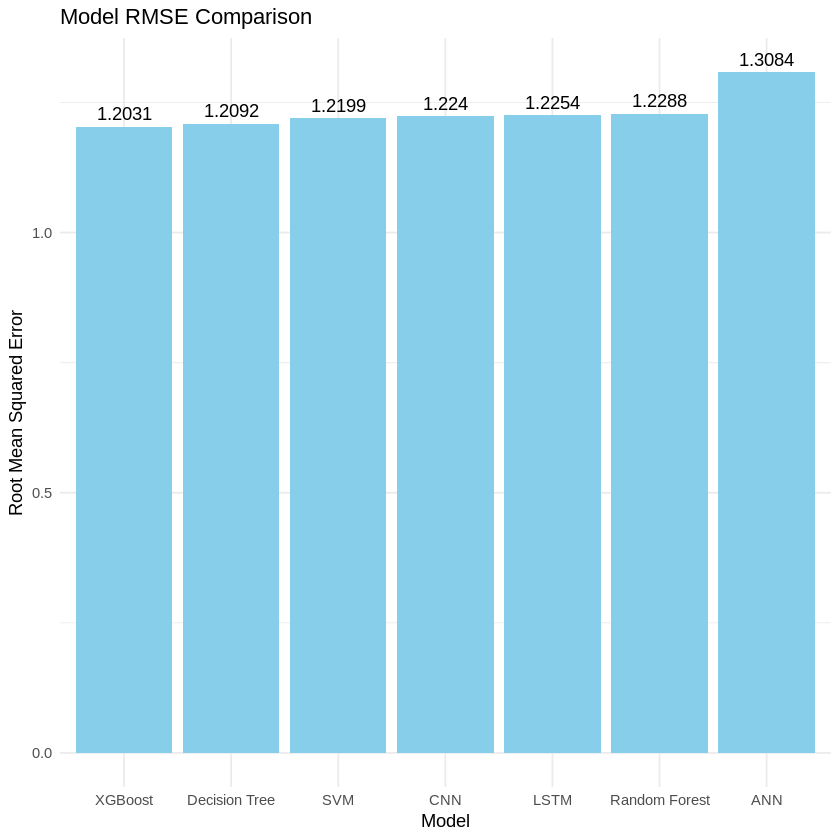

In [56]:
# Plot RMSE comparison
cat("Plotting RMSE comparison...\n")
ggplot(results, aes(x = reorder(Model, RMSE), y = RMSE)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  geom_text(aes(label = round(RMSE, 4)), vjust = -0.5) +
  labs(title = "Model RMSE Comparison", x = "Model", y = "Root Mean Squared Error") +
  theme_minimal()

Plotting training time comparison...


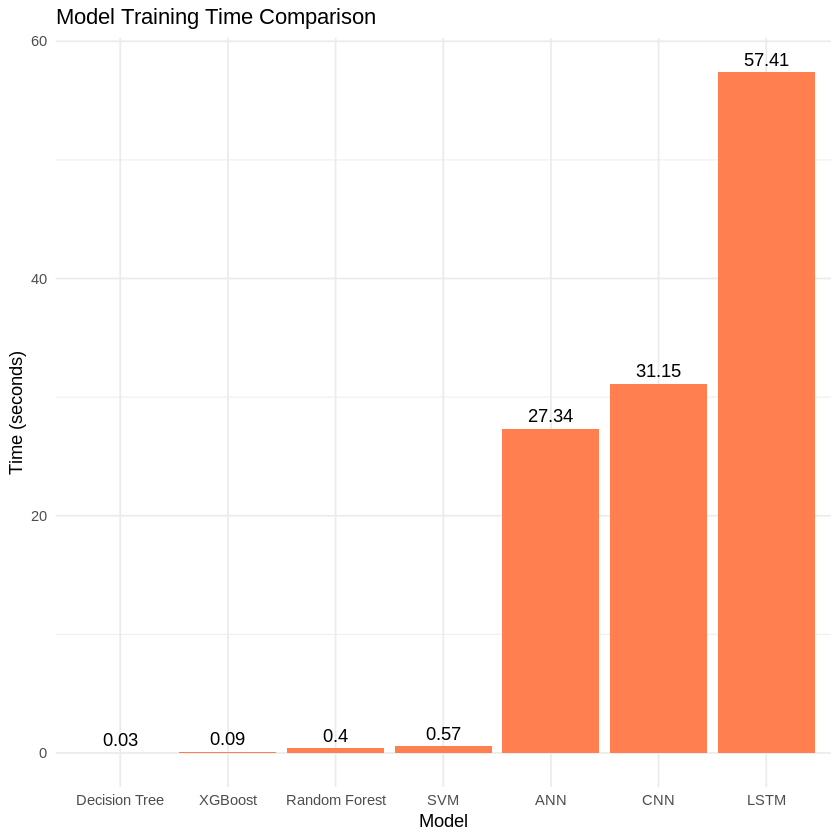

In [57]:
# Plot training times comparison
cat("Plotting training time comparison...\n")
ggplot(results, aes(x = reorder(Model, Time), y = Time)) +
  geom_bar(stat = "identity", fill = "coral") +
  geom_text(aes(label = round(Time, 2)), vjust = -0.5) +
  labs(title = "Model Training Time Comparison", x = "Model", y = "Time (seconds)") +
  theme_minimal()